## Q44-46. Hough変換・直線検出

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

### 画像抽出

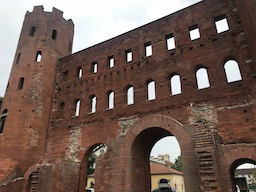

In [3]:
original_image = Image.open('dataset/thorino.jpg')
display(original_image)

### グレー化+ノイズ除去+エッジ化

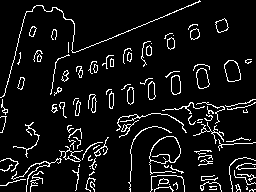

In [4]:
gray_image = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2GRAY)
blured_image = cv2.GaussianBlur(gray_image, (5, 5), 1.4)
edges_image = cv2.Canny(blured_image, 30, 100)
display(Image.fromarray(edges_image))

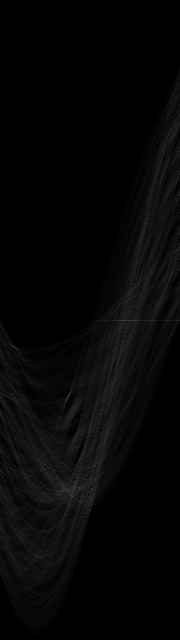

In [11]:
# 1. 画像の対角線の長さを求める
height, width = edges_image.shape
rmax = int(np.sqrt(height**2 + width**2))

hough_image = np.zeros((2 * rmax, 180), dtype=np.uint16)

# 2. Hough変換を実行する
rho = np.empty(0)
edge_area = np.where(edges_image == 255)

for h, w in zip(edge_area[0], edge_area[1]):
        for theta in range(0, 180):
            r = int(w * np.cos(np.deg2rad(theta)) + h * np.sin(np.deg2rad(theta)))
            # 3. ボーディングを実装
            hough_image[r + rmax, theta] += 1

display(Image.fromarray(hough_image.astype(np.uint8)))

### Q44の回答

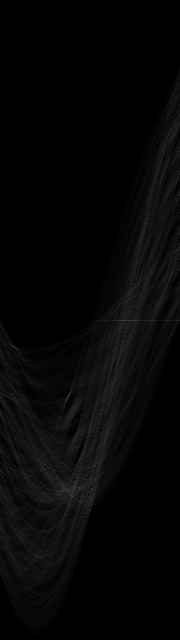

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def Canny(img):

	# Gray scale
	def BGR2GRAY(img):
		b = img[:, :, 0].copy()
		g = img[:, :, 1].copy()
		r = img[:, :, 2].copy()

		# Gray scale
		out = 0.2126 * r + 0.7152 * g + 0.0722 * b
		out = out.astype(np.uint8)

		return out


	# Gaussian filter for grayscale
	def gaussian_filter(img, K_size=3, sigma=1.3):

		if len(img.shape) == 3:
			H, W, C = img.shape
			gray = False
		else:
			img = np.expand_dims(img, axis=-1)
			H, W, C = img.shape
			gray = True

		## Zero padding
		pad = K_size // 2
		out = np.zeros([H + pad * 2, W + pad * 2, C], dtype=np.float32)
		out[pad : pad + H, pad : pad + W] = img.copy().astype(np.float32)

		## prepare Kernel
		K = np.zeros((K_size, K_size), dtype=np.float32)
		for x in range(-pad, -pad + K_size):
			for y in range(-pad, -pad + K_size):
				K[y + pad, x + pad] = np.exp( - (x ** 2 + y ** 2) / (2 * sigma * sigma))
		#K /= (sigma * np.sqrt(2 * np.pi))
		K /= (2 * np.pi * sigma * sigma)
		K /= K.sum()

		tmp = out.copy()

		# filtering
		for y in range(H):
			for x in range(W):
				for c in range(C):
					out[pad + y, pad + x, c] = np.sum(K * tmp[y : y + K_size, x : x + K_size, c])

		out = np.clip(out, 0, 255)
		out = out[pad : pad + H, pad : pad + W]
		out = out.astype(np.uint8)

		if gray:
			out = out[..., 0]

		return out


	# sobel filter
	def sobel_filter(img, K_size=3):
		if len(img.shape) == 3:
			H, W, C = img.shape
		else:
			H, W = img.shape

		# Zero padding
		pad = K_size // 2
		out = np.zeros((H + pad * 2, W + pad * 2), dtype=np.float32)
		out[pad : pad + H, pad : pad + W] = img.copy().astype(np.float32)
		tmp = out.copy()

		out_v = out.copy()
		out_h = out.copy()

		## Sobel vertical
		Kv = [[1., 2., 1.],[0., 0., 0.], [-1., -2., -1.]]
		## Sobel horizontal
		Kh = [[1., 0., -1.],[2., 0., -2.],[1., 0., -1.]]

		# filtering
		for y in range(H):
			for x in range(W):
				out_v[pad + y, pad + x] = np.sum(Kv * (tmp[y : y + K_size, x : x + K_size]))
				out_h[pad + y, pad + x] = np.sum(Kh * (tmp[y : y + K_size, x : x + K_size]))

		out_v = np.clip(out_v, 0, 255)
		out_h = np.clip(out_h, 0, 255)

		out_v = out_v[pad : pad + H, pad : pad + W]
		out_v = out_v.astype(np.uint8)
		out_h = out_h[pad : pad + H, pad : pad + W]
		out_h = out_h.astype(np.uint8)

		return out_v, out_h


	def get_edge_angle(fx, fy):
		# get edge strength
		edge = np.sqrt(np.power(fx.astype(np.float32), 2) + np.power(fy.astype(np.float32), 2))
		edge = np.clip(edge, 0, 255)

		fx = np.maximum(fx, 1e-10)
		#fx[np.abs(fx) <= 1e-5] = 1e-5

		# get edge angle
		angle = np.arctan(fy / fx)

		return edge, angle


	def angle_quantization(angle):
		angle = angle / np.pi * 180
		angle[angle < -22.5] = 180 + angle[angle < -22.5]
		_angle = np.zeros_like(angle, dtype=np.uint8)
		_angle[np.where(angle <= 22.5)] = 0
		_angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
		_angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
		_angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135

		return _angle


	def non_maximum_suppression(angle, edge):
		H, W = angle.shape
		_edge = edge.copy()
		
		for y in range(H):
			for x in range(W):
					if angle[y, x] == 0:
							dx1, dy1, dx2, dy2 = -1, 0, 1, 0
					elif angle[y, x] == 45:
							dx1, dy1, dx2, dy2 = -1, 1, 1, -1
					elif angle[y, x] == 90:
							dx1, dy1, dx2, dy2 = 0, -1, 0, 1
					elif angle[y, x] == 135:
							dx1, dy1, dx2, dy2 = -1, -1, 1, 1
					if x == 0:
							dx1 = max(dx1, 0)
							dx2 = max(dx2, 0)
					if x == W-1:
							dx1 = min(dx1, 0)
							dx2 = min(dx2, 0)
					if y == 0:
							dy1 = max(dy1, 0)
							dy2 = max(dy2, 0)
					if y == H-1:
							dy1 = min(dy1, 0)
							dy2 = min(dy2, 0)
					if max(max(edge[y, x], edge[y + dy1, x + dx1]), edge[y + dy2, x + dx2]) != edge[y, x]:
							_edge[y, x] = 0

		return _edge

	def hysterisis(edge, HT=100, LT=30):
		H, W = edge.shape

		# Histeresis threshold
		edge[edge >= HT] = 255
		edge[edge <= LT] = 0

		_edge = np.zeros((H + 2, W + 2), dtype=np.float32)
		_edge[1 : H + 1, 1 : W + 1] = edge

		## 8 - Nearest neighbor
		nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

		for y in range(1, H+2):
				for x in range(1, W+2):
						if _edge[y, x] < LT or _edge[y, x] > HT:
								continue
						if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
								_edge[y, x] = 255
						else:
								_edge[y, x] = 0

		edge = _edge[1:H+1, 1:W+1]
								
		return edge

	# grayscale
	gray = BGR2GRAY(img)

	# gaussian filtering
	gaussian = gaussian_filter(gray, K_size=5, sigma=1.4)

	# sobel filtering
	fy, fx = sobel_filter(gaussian, K_size=3)

	# get edge strength, angle
	edge, angle = get_edge_angle(fx, fy)

	# angle quantization
	angle = angle_quantization(angle)

	# non maximum suppression
	edge = non_maximum_suppression(angle, edge)

	# hysterisis threshold
	out = hysterisis(edge, 100, 30)

	return out


def Hough_Line_step1(edge):
	## Voting
	def voting(edge):
		H, W = edge.shape
		dtheta = 1

		# get rho max length
		rho_max = int(np.ceil(np.sqrt(H ** 2 + W ** 2)))

		# hough table
		hough = np.zeros((rho_max * 2, 180), dtype=np.int16)

		# get index of edge
		ind = np.where(edge == 255)

		## hough transformation
		for y, x in zip(ind[0], ind[1]):
				for theta in range(0, 180, dtheta):
						# get polar coordinat4s
						t = np.pi / 180 * theta
						rho = int(x * np.cos(t) + y * np.sin(t))

						# vote
						hough[rho + rho_max, theta] += 1
							
		out = hough.astype(np.uint8)

		return out

	# voting
	out = voting(edge)

	return out


# Read image
img = cv2.imread("dataset/thorino.jpg").astype(np.float32)

# Canny
edge = Canny(img)

# Hough
out = Hough_Line_step1(edge)

out = out.astype(np.uint8)

display(Image.fromarray(out))

In [ ]:
# 周囲の8ピクセルより大きい値であれば、残す。それ以外は0にする処理を施す
nms_size = 1
h, w = hough_image.shape
peaks = []

for i in range(1, h):
    for j in range(1, w):
        patch_area = hough_image[i-1:i+1, j-1:j+1]

        if hough_image[i,j] == np.max(patch_area) and hough_image[i, j]!=0:
            peaks.append(((i,j), hough_image[i,j]))

peaks_top20 = sorted(peaks, key=lambda x: x[1], reverse=True)[:20]
peaks_top20

[((396, 68), np.uint16(87)),
 ((398, 67), np.uint16(86)),
 ((489, 67), np.uint16(64)),
 ((495, 71), np.uint16(64)),
 ((320, 124), np.uint16(63)),
 ((320, 128), np.uint16(63)),
 ((320, 122), np.uint16(61)),
 ((481, 75), np.uint16(61)),
 ((320, 131), np.uint16(60)),
 ((492, 91), np.uint16(60)),
 ((492, 72), np.uint16(59)),
 ((176, 178), np.uint16(58)),
 ((320, 135), np.uint16(58)),
 ((465, 94), np.uint16(58)),
 ((467, 89), np.uint16(57)),
 ((488, 64), np.uint16(57)),
 ((347, 14), np.uint16(55)),
 ((456, 2), np.uint16(55)),
 ((472, 45), np.uint16(55)),
 ((483, 74), np.uint16(55))]

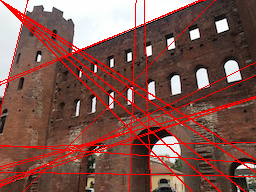

In [83]:
H, W = gray_image.shape

output = np.array(original_image).copy()

# ハフ変換の逆を実装
for i, _ in peaks_top20:
    t = np.deg2rad(i[1])
    rho = i[0] - hough_image.shape[0] / 2
    for x in range(W):
        if np.sin(t) != 0:
            y = - (np.cos(t) / np.sin(t)) * x + (rho) / np.sin(t)
            y = int(y)
            if y >= H or y < 0:
                continue
            output[y, x] = [255, 0, 0]
    for y in range(H):
        if np.cos(t) != 0:
            x = - (np.sin(t) / np.cos(t)) * y + (rho) / np.cos(t)
            x = int(x)
            if x >= W or x < 0:
                continue
            output[y, x] = [255, 0, 0]


display(Image.fromarray(output))
